# Hyperparameter Tuning with MLflow and Optuna
When building machine learning models, you must choose a model's given parameters to yield the best possible inference performance

But Hyperparameter tuning creates a large number of combinations of parameters as well as output metrics

MLflow and Optuna help make that managable


## An End to End showcase of building a machine learning model
You will see
1. How to set up your training environment with Mlflow tracking
2. How to generate a trainig and evaluation data set
3. Define an objective function
4. How to use Optuna to tune hyper-paramters
5. Using MLflow child runs to track hyper-paremter tuning


Source [Hyperparameter Tuning with MLflow and Optuna](https://mlflow.org/docs/latest/traditional-ml/hyperparameter-tuning-with-child-runs/index.html)

Python requirements
```bash
numpy==1.26.4
optuna==4.2.1
pandas==2.2.3
scikit-learn==1.2.2  
mlflow==2.20.3
```

In [59]:
import math
from datetime import datetime, timedelta

import numpy as np
import optuna
import pandas as pd
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

import mlflow

## Configure the tracking server URI

In [60]:
# Set credentials
import os

os.environ["MLFLOW_TRACKING_URI"] = "http://mlflow.mlnow.frenoid.com:30080/"
os.environ["MLFLOW_TRACKING_USERNAME"] = "mlflow"
os.environ["MLFLOW_TRACKING_PASSWORD"] = "mlflow"

mlflow.set_tracking_uri(os.environ["MLFLOW_TRACKING_URI"])

## Generate our synthetic training data
Generates a synthetic dataset for predicting apple sales demand

In [61]:
def generate_apple_sales_data_with_promo_adjustment(
  base_demand: int = 1000,
  n_rows: int = 5000,
  competitor_price_effect: float = -50.0,
):
  """
  Generates a synthetic dataset for predicting apple sales demand with multiple
  influencing factors.

  This function creates a pandas DataFrame with features relevant to apple sales.
  The features include date, average_temperature, rainfall, weekend flag, holiday flag,
  promotional flag, price_per_kg, competitor's price, marketing intensity, stock availability,
  and the previous day's demand. The target variable, 'demand', is generated based on a
  combination of these features with some added noise.

  Args:
      base_demand (int, optional): Base demand for apples. Defaults to 1000.
      n_rows (int, optional): Number of rows (days) of data to generate. Defaults to 5000.
      competitor_price_effect (float, optional): Effect of competitor's price being lower
                                                 on our sales. Defaults to -50.

  Returns:
      pd.DataFrame: DataFrame with features and target variable for apple sales prediction.

  Example:
      >>> df = generate_apple_sales_data_with_promo_adjustment(base_demand=1200, n_rows=6000)
      >>> df.head()
  """

  # Set seed for reproducibility
  np.random.seed(9999)

  # Create date range
  dates = [datetime.now() - timedelta(days=i) for i in range(n_rows)]
  dates.reverse()

  # Generate features
  df = pd.DataFrame(
      {
          "date": dates,
          "average_temperature": np.random.uniform(10, 35, n_rows),
          "rainfall": np.random.exponential(5, n_rows),
          "weekend": [(date.weekday() >= 5) * 1 for date in dates],
          "holiday": np.random.choice([0, 1], n_rows, p=[0.97, 0.03]),
          "price_per_kg": np.random.uniform(0.5, 3, n_rows),
          "month": [date.month for date in dates],
      }
  )

  # Introduce inflation over time (years)
  df["inflation_multiplier"] = 1 + (df["date"].dt.year - df["date"].dt.year.min()) * 0.03

  # Incorporate seasonality due to apple harvests
  df["harvest_effect"] = np.sin(2 * np.pi * (df["month"] - 3) / 12) + np.sin(
      2 * np.pi * (df["month"] - 9) / 12
  )

  # Modify the price_per_kg based on harvest effect
  df["price_per_kg"] = df["price_per_kg"] - df["harvest_effect"] * 0.5

  # Adjust promo periods to coincide with periods lagging peak harvest by 1 month
  peak_months = [4, 10]  # months following the peak availability
  df["promo"] = np.where(
      df["month"].isin(peak_months),
      1,
      np.random.choice([0, 1], n_rows, p=[0.85, 0.15]),
  )

  # Generate target variable based on features
  base_price_effect = -df["price_per_kg"] * 50
  seasonality_effect = df["harvest_effect"] * 50
  promo_effect = df["promo"] * 200

  df["demand"] = (
      base_demand
      + base_price_effect
      + seasonality_effect
      + promo_effect
      + df["weekend"] * 300
      + np.random.normal(0, 50, n_rows)
  ) * df["inflation_multiplier"]  # adding random noise

  # Add previous day's demand
  df["previous_days_demand"] = df["demand"].shift(1)
  df["previous_days_demand"].fillna(method="bfill", inplace=True)  # fill the first row

  # Introduce competitor pricing
  df["competitor_price_per_kg"] = np.random.uniform(0.5, 3, n_rows)
  df["competitor_price_effect"] = (
      df["competitor_price_per_kg"] < df["price_per_kg"]
  ) * competitor_price_effect

  # Stock availability based on past sales price (3 days lag with logarithmic decay)
  log_decay = -np.log(df["price_per_kg"].shift(3) + 1) + 2
  df["stock_available"] = np.clip(log_decay, 0.7, 1)

  # Marketing intensity based on stock availability
  # Identify where stock is above threshold
  high_stock_indices = df[df["stock_available"] > 0.95].index

  # For each high stock day, increase marketing intensity for the next week
  for idx in high_stock_indices:
      df.loc[idx : min(idx + 7, n_rows - 1), "marketing_intensity"] = np.random.uniform(0.7, 1)

  # If the marketing_intensity column already has values, this will preserve them;
  #  if not, it sets default values
  fill_values = pd.Series(np.random.uniform(0, 0.5, n_rows), index=df.index)
  df["marketing_intensity"].fillna(fill_values, inplace=True)

  # Adjust demand with new factors
  df["demand"] = df["demand"] + df["competitor_price_effect"] + df["marketing_intensity"]

  # Drop temporary columns
  df.drop(
      columns=[
          "inflation_multiplier",
          "harvest_effect",
          "month",
          "competitor_price_effect",
          "stock_available",
      ],
      inplace=True,
  )

  return df

### Generate 5000 rows of data

In [41]:
df = generate_apple_sales_data_with_promo_adjustment(base_demand=1_000, n_rows=5000)
df

/tmp/ipykernel_933286/2891652786.py:85: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["previous_days_demand"].fillna(method="bfill", inplace=True)  # fill the first row
/tmp/ipykernel_933286/2891652786.py:85: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["previous_days_demand"].fillna(method="bfill", inplace=True)  # fill the first row
/tmp/ipykernel_933286/2891652786.py:108: FutureWarning: A value is trying to be set on a copy of a 

,date,average_temperature,rainfall,weekend,holiday,price_per_kg,promo,demand,previous_days_demand,competitor_price_per_kg,marketing_intensity
0,2011-07-21 12:35:27.470708,30.584727,1.199291,0,0,1.726258,0,851.375336,851.276659,1.935346,0.098677
1,2011-07-22 12:35:27.470708,15.465069,1.037626,0,0,0.576471,0,906.855943,851.276659,2.344720,0.019318
2,2011-07-23 12:35:27.470707,10.786525,5.656089,1,0,2.513328,0,1108.304909,906.836626,0.998803,0.409485
3,2011-07-24 12:35:27.470707,23.648154,12.030937,1,0,1.839225,0,1099.833810,1157.895424,0.761740,0.872803
4,2011-07-25 12:35:27.470706,13.861391,4.303812,0,0,1.531772,0,983.949061,1148.961007,2.123436,0.820779
...,...,...,...,...,...,...,...,...,...,...,...
4995,2025-03-24 12:35:27.468936,21.643051,3.821656,0,0,2.391010,0,1165.882437,1596.799278,1.504432,0.756489
4996,2025-03-25 12:35:27.468936,13.808813,1.080603,0,1,0.898693,0,1312.870527,1215.125948,1.343586,0.742145
4997,2025-03-26 12:35:27.468935,11.698227,1.911000,0,0,2.839860,0,987.065524,1312.128382,2.771896,0.742145
4998,2025-03-27 12:35:27.468935,18.052081,1.000521,0,0,1.188440,0,1397.886638,1036.323379,2.564075,0.742145


In [62]:
import matplotlib.pyplot as plt
import seaborn as sns


def plot_correlation_with_demand(df, save_path=None):  # noqa: D417
  """
  Plots the correlation of each variable in the dataframe with the 'demand' column.

  Args:
  - df (pd.DataFrame): DataFrame containing the data, including a 'demand' column.
  - save_path (str, optional): Path to save the generated plot. If not specified, plot won't be saved.

  Returns:
  - None (Displays the plot on a Jupyter window)
  """

  # Compute correlations between all variables and 'demand'
  correlations = df.corr()["demand"].drop("demand").sort_values()

  # Generate a color palette from red to green
  colors = sns.diverging_palette(10, 130, as_cmap=True)
  color_mapped = correlations.map(colors)

  # Set Seaborn style
  sns.set_style(
      "whitegrid", {"axes.facecolor": "#c2c4c2", "grid.linewidth": 1.5}
  )  # Light grey background and thicker grid lines

  # Create bar plot
  fig = plt.figure(figsize=(12, 8))
  plt.barh(correlations.index, correlations.values, color=color_mapped)

  # Set labels and title with increased font size
  plt.title("Correlation with Demand", fontsize=18)
  plt.xlabel("Correlation Coefficient", fontsize=16)
  plt.ylabel("Variable", fontsize=16)
  plt.xticks(fontsize=14)
  plt.yticks(fontsize=14)
  plt.grid(axis="x")

  plt.tight_layout()

  # Save the plot if save_path is specified
  if save_path:
      plt.savefig(save_path, format="png", dpi=600)

  # prevent matplotlib from displaying the chart every time we call this function
  plt.close(fig)

  return fig


# Test the function
correlation_plot = plot_correlation_with_demand(df, save_path="correlation_plot.png")

## Examining Feature-Target Correlations
Understand the relationships between the features and the target variable

1. Find if any featyre correlates perfectly with target - correlation coefficient of 1.0
2. Check if the features have a strong or weak correlation with the target.
3. Make the model training process auditable and tracerable

In [43]:
correlation_plot = plot_correlation_with_demand(df, save_path="correlation_plot.png")

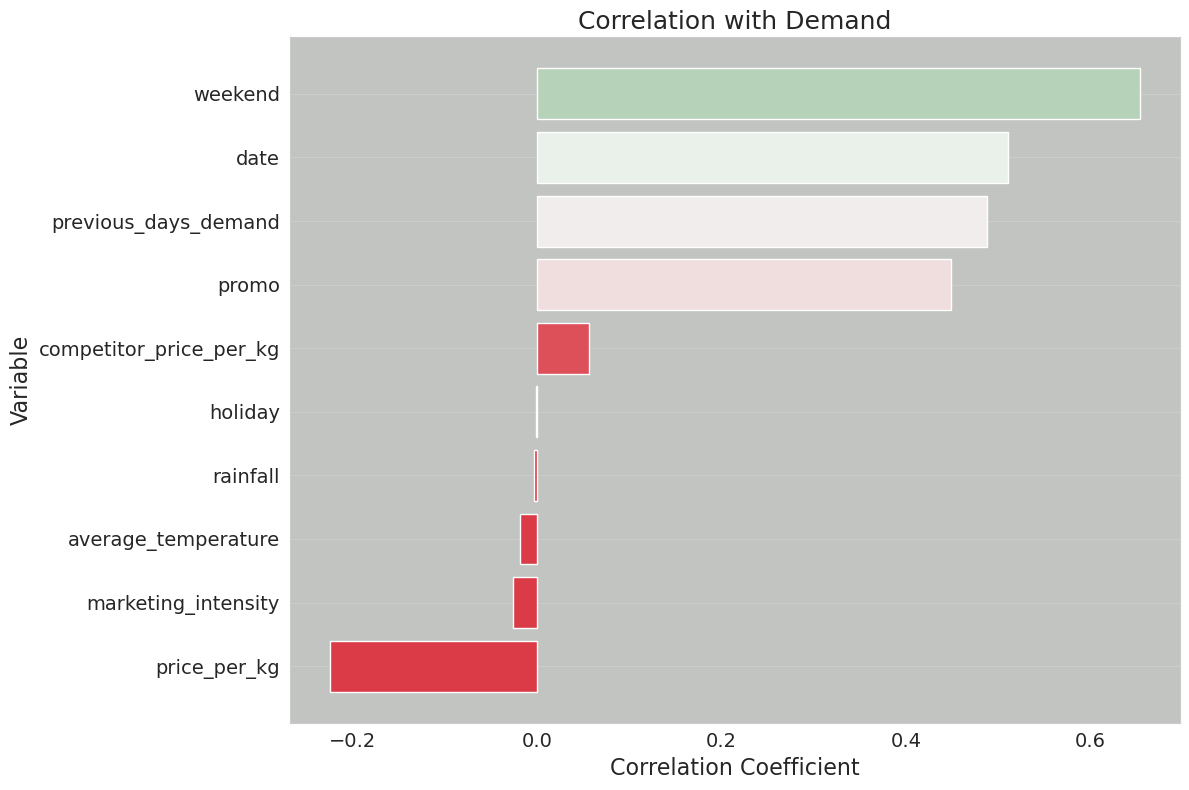

In [44]:
correlation_plot

## Why log visualizations in MLflow

It is a good idea to log visualizations to MLflow because

1. Notebooks are not permenant records of work
2. Re-running parts of notebook causes the plot to become outdate
3. Re-running the entire notebook causes the state to be lost

MLflow is designed as a *permanent easily accessible record*

In [45]:
def plot_residuals(model, dvalid, valid_y, save_path=None):  # noqa: D417
  """
  Plots the residuals of the model predictions against the true values.

  Args:
  - model: The trained XGBoost model.
  - dvalid (xgb.DMatrix): The validation data in XGBoost DMatrix format.
  - valid_y (pd.Series): The true values for the validation set.
  - save_path (str, optional): Path to save the generated plot. If not specified, plot won't be saved.

  Returns:
  - None (Displays the residuals plot on a Jupyter window)
  """

  # Predict using the model
  preds = model.predict(dvalid)

  # Calculate residuals
  residuals = valid_y - preds

  # Set Seaborn style
  sns.set_style("whitegrid", {"axes.facecolor": "#c2c4c2", "grid.linewidth": 1.5})

  # Create scatter plot
  fig = plt.figure(figsize=(12, 8))
  plt.scatter(valid_y, residuals, color="blue", alpha=0.5)
  plt.axhline(y=0, color="r", linestyle="-")

  # Set labels, title and other plot properties
  plt.title("Residuals vs True Values", fontsize=18)
  plt.xlabel("True Values", fontsize=16)
  plt.ylabel("Residuals", fontsize=16)
  plt.xticks(fontsize=14)
  plt.yticks(fontsize=14)
  plt.grid(axis="y")

  plt.tight_layout()

  # Save the plot if save_path is specified
  if save_path:
      plt.savefig(save_path, format="png", dpi=600)

  # Show the plot
  plt.close(fig)

  return fig

### Understanding Feature Importance with XGBoost

The plot_feature_importance function is designed to visualize the importance of each feature used in our XGBoost model. Understanding feature importance can offer critical insights into the model's decision-making process and can aid in feature selection, engineering, and interpretation.

#### Types of Feature Importance
XGBoost offers multiple ways to interpret feature importance. This function supports:

* `Weight`: Number of times a feature appears in a tree across the ensemble of trees (for gblinear booster).
* `Gain`: Average gain (or improvement to the model) of the feature when it is used in trees (for other booster types).

We automatically select the appropriate importance type based on the booster used in the XGBoost model.

#### Why Feature Importance Matters
Understanding feature importance offers several advantages:

* `Interpretability`: Knowing which features are most influential helps us understand the model better.
* `Feature Selection`: Unimportant features can potentially be dropped to simplify the model.
* `Domain Understanding`: Aligns the model's importance scale with domain-specific knowledge or intuition.

In [46]:
def plot_feature_importance(model, booster):  # noqa: D417
  """
  Plots feature importance for an XGBoost model.

  Args:
  - model: A trained XGBoost model

  Returns:
  - fig: The matplotlib figure object
  """
  fig, ax = plt.subplots(figsize=(10, 8))
  importance_type = "weight" if booster == "gblinear" else "gain"
  xgb.plot_importance(
      model,
      importance_type=importance_type,
      ax=ax,
      title=f"Feature Importance based on {importance_type}",
  )
  plt.tight_layout()
  plt.close(fig)

  return fig

To preserve a permenant record of this training run - we will also save the plot to MLflow

### Create an experiment for our hyperparameter tuning runs

In [47]:
def get_or_create_experiment(experiment_name):
  """
  Retrieve the ID of an existing MLflow experiment or create a new one if it doesn't exist.

  This function checks if an experiment with the given name exists within MLflow.
  If it does, the function returns its ID. If not, it creates a new experiment
  with the provided name and returns its ID.

  Parameters:
  - experiment_name (str): Name of the MLflow experiment.

  Returns:
  - str: ID of the existing or newly created MLflow experiment.
  """

  if experiment := mlflow.get_experiment_by_name(experiment_name):
      return experiment.experiment_id
  else:
      return mlflow.create_experiment(experiment_name)

experiment_id = get_or_create_experiment("Apples Demand")

In [48]:
experiment_id

'1'

## Setting Up the MLflow experiment
Before we start our hyperparameter tuning process, we need to designate a specific "experiment" within MLflow to track and log our results. An experiment in MLflow is essentially a named set of runs. Each run within an experiment tracks its own parameters, metrics, tags, and artifacts.

In [55]:
# Set the current active MLflow experiment
mlflow.set_experiment(experiment_id=experiment_id)

<Experiment: artifact_location='mlflow-artifacts:/1', creation_time=1743094111843, experiment_id='1', last_update_time=1743094111843, lifecycle_stage='active', name='Apples Demand', tags={}>

## Data Preprocessing
The next steps involve preparing the dataset for model training:

1. `Feature Selection`: We drop the columns 'date' and 'demand' from our DataFrame.

2. `Target Variable`: Make the 'demand' column our target variable

2. `Data Splitting`: We split the dataset into training (train_x, train_y) and validation (valid_x, valid_y) sets using a 75-25 split.

4. `XGBoost Data Format`: Finally, we convert the training and validation datasets into XGBoost's DMatrix format. This optimized data structure speeds up the training process and is required for using XGBoost's advanced functionalities.

In [21]:
X = df.drop(columns=["date", "demand"])
y = df["demand"]
train_x, valid_x, train_y, valid_y = train_test_split(X, y, test_size=0.25)
dtrain = xgb.DMatrix(train_x, label=train_y)
dvalid = xgb.DMatrix(valid_x, label=valid_y)

### Define the objective function


### Optuna and MLflow
* `Automated Tuning`: Optuna automates the process of finding the best hyperparameters.
* `Experiment Tracking`: MLflow allows us to keep track of each run's hyperparameters and performance metrics, making it easier to analyze, compare, and reproduce experiments later.

In [54]:
def objective(trial):
  with mlflow.start_run(nested=True):
      # Define hyperparameters
      params = {
          "objective": "reg:squarederror",
          "eval_metric": "rmse",
          "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
          "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
          "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
      }

      if params["booster"] == "gbtree" or params["booster"] == "dart":
          params["max_depth"] = trial.suggest_int("max_depth", 1, 9)
          params["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
          params["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
          params["grow_policy"] = trial.suggest_categorical(
              "grow_policy", ["depthwise", "lossguide"]
          )

      # Train XGBoost model
      bst = xgb.train(params, dtrain)
      preds = bst.predict(dvalid)
      error = mean_squared_error(valid_y, preds)

      # Log to MLflow
      mlflow.log_params(params)  # Log the model hyper-parameters
      mlflow.log_metric("mse", error)  # Log the model MSE metric
      mlflow.log_metric("rmse", math.sqrt(error))  # Log the model RMSE metric

  return error

### Streamlining Logging for Optuna Trials

Reduce the amount of logs by updating only when a new hyperparameter combination improves the loss function

In [53]:
# override Optuna's default logging to ERROR only
optuna.logging.set_verbosity(optuna.logging.ERROR)

# define a logging callback that will report on only new challenger parameter configurations if a
# trial has usurped the state of 'best conditions'


def champion_callback(study, frozen_trial):
  """
  Logging callback that will report when a new trial iteration improves upon existing
  best trial values.

  Note: This callback is not intended for use in distributed computing systems such as Spark
  or Ray due to the micro-batch iterative implementation for distributing trials to a cluster's
  workers or agents.
  The race conditions with file system state management for distributed trials will render
  inconsistent values with this callback.
  """

  winner = study.user_attrs.get("winner", None)

  if study.best_value and winner != study.best_value:
      study.set_user_attr("winner", study.best_value)
      if winner:
          improvement_percent = (abs(winner - study.best_value) / study.best_value) * 100
          print(
              f"Trial {frozen_trial.number} achieved value: {frozen_trial.value} with "
              f"{improvement_percent: .4f}% improvement"
          )
      else:
          print(f"Initial trial {frozen_trial.number} achieved value: {frozen_trial.value}")

## Orchestrae Hyperparameter Tuning, Model Training, and Logging with MLflow
This section brings all the components together

### Why Model Serialization and Logging is crucial 
* `End-to-End Workflow`: This code block represents an end-to-end machine learning workflow, from hyperparameter tuning to model evaluation and logging.
* `Reproducibility`: All details about the model, including hyperparameters, metrics, and visual diagnostics, are logged, ensuring that the experiment is fully reproducible.
* `Analysis and Comparison`: With all data logged in MLflow, it becomes easier to analyze the performance of various runs and choose the best model for deployment.

In [67]:
NUMBER_OF_TRIALS = 20

In [68]:
run_name = "third_attempt"

In [69]:
# Initiate the parent run and call the hyperparameter tuning child run logic
with mlflow.start_run(experiment_id=experiment_id, run_name=run_name, nested=True):
  # Initialize the Optuna study
  study = optuna.create_study(direction="minimize") # Minimize the objective function

  # Execute the hyperparameter optimization trials.
  # Note the addition of the `champion_callback` inclusion to control our logging
  study.optimize(objective, n_trials=NUMBER_OF_TRIALS, callbacks=[champion_callback])

  mlflow.log_params(study.best_params)
  mlflow.log_metric("best_mse", study.best_value)
  mlflow.log_metric("best_rmse", math.sqrt(study.best_value))

  # Log tags in MLflow
  # we log additional metadata like the project name, optimization engine, 
  # model family,and feature set version. 
  # This helps in better categorizing and understanding the context of the model run.
  mlflow.set_tags(
      tags={
          "project": "Apple Demand Project",
          "optimizer_engine": "optuna",
          "model_family": "xgboost",
          "feature_set_version": 1,
      }
  )

  # Log a fit model instance
  model = xgb.train(study.best_params, dtrain)

  # Log the correlation plot
  mlflow.log_figure(figure=correlation_plot, artifact_file="correlation_plot.png")

  # Log the feature importances plot
  importances = plot_feature_importance(model, booster=study.best_params.get("booster"))
  mlflow.log_figure(figure=importances, artifact_file="feature_importances.png")

  # Log the residuals plot
  residuals = plot_residuals(model, dvalid, valid_y)
  mlflow.log_figure(figure=residuals, artifact_file="residuals.png")

  artifact_path = "model"

  # Model Serialization and Logging
  # the trained model is logged to MLflow using mlflow.xgboost.log_model, 
  # along with an example input and additional metadata. 
  # The model is stored in a specified artifact path and its URI is retrieved.
  mlflow.xgboost.log_model(
      xgb_model=model,
      artifact_path=artifact_path,
      input_example=train_x.iloc[[0]],
      model_format="ubj",
      metadata={"model_data_version": 1},
  )

  # Get the logged model uri so that we can load it from the artifact store
  model_uri = mlflow.get_artifact_uri(artifact_path)

🏃 View run abundant-kit-292 at: http://mlflow.mlnow.frenoid.com:30080/#/experiments/1/runs/ef73a179716249c898fe30749723f797
🧪 View experiment at: http://mlflow.mlnow.frenoid.com:30080/#/experiments/1
Initial trial 0 achieved value: 14859.199961468032
🏃 View run unleashed-grub-231 at: http://mlflow.mlnow.frenoid.com:30080/#/experiments/1/runs/d5bdb930cb7e409f9f9aabfb83692988
🧪 View experiment at: http://mlflow.mlnow.frenoid.com:30080/#/experiments/1
🏃 View run nimble-penguin-698 at: http://mlflow.mlnow.frenoid.com:30080/#/experiments/1/runs/1fc471232fd2439dac38d6c12e7cca2d
🧪 View experiment at: http://mlflow.mlnow.frenoid.com:30080/#/experiments/1
🏃 View run welcoming-mouse-683 at: http://mlflow.mlnow.frenoid.com:30080/#/experiments/1/runs/119a88f4a7d34faf8a34b9dfe3217bf4
🧪 View experiment at: http://mlflow.mlnow.frenoid.com:30080/#/experiments/1
🏃 View run popular-bird-909 at: http://mlflow.mlnow.frenoid.com:30080/#/experiments/1/runs/efcf086cdbe849e78b14147f1cae4bd9
🧪 View experiment 

/opt/conda/envs/python3-11/lib/python3.11/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


🏃 View run third_attempt at: http://mlflow.mlnow.frenoid.com:30080/#/experiments/1/runs/57b3cc2aa1b743ecbf998c59bd575d8c
🧪 View experiment at: http://mlflow.mlnow.frenoid.com:30080/#/experiments/1


### model_uri
The model_uri serves as a consistent, abstracted reference to your model and its associated data.

In [72]:
model_uri

'mlflow-artifacts:/1/57b3cc2aa1b743ecbf998c59bd575d8c/artifacts/model'

### Load a trained model from MLflow

In [73]:
loaded = mlflow.xgboost.load_model(model_uri)

### Example: Batch Inference Using the Loaded Model

In [76]:
# convert our features (X) into XGBoost's optimized DMatrix format. 
# This data structure is specifically designed for efficiency and speed in XGBoost.
batch_dmatrix = xgb.DMatrix(X)

# Perform batch inference on entire dataset
inference = loaded.predict(batch_dmatrix)

# Make a copy of the original dataframe
infer_df = df.copy()

# Add the perdictions as a new column to the dataframe
infer_df["predicted_demand"] = inference

In [77]:
infer_df

,date,average_temperature,rainfall,weekend,holiday,price_per_kg,promo,demand,previous_days_demand,competitor_price_per_kg,marketing_intensity,predicted_demand
0,2011-07-21 12:35:27.470708,30.584727,1.199291,0,0,1.726258,0,851.375336,851.276659,1.935346,0.098677,984.067261
1,2011-07-22 12:35:27.470708,15.465069,1.037626,0,0,0.576471,0,906.855943,851.276659,2.344720,0.019318,993.419373
2,2011-07-23 12:35:27.470707,10.786525,5.656089,1,0,2.513328,0,1108.304909,906.836626,0.998803,0.409485,895.684692
3,2011-07-24 12:35:27.470707,23.648154,12.030937,1,0,1.839225,0,1099.833810,1157.895424,0.761740,0.872803,1257.947266
4,2011-07-25 12:35:27.470706,13.861391,4.303812,0,0,1.531772,0,983.949061,1148.961007,2.123436,0.820779,1454.987915
...,...,...,...,...,...,...,...,...,...,...,...,...
4995,2025-03-24 12:35:27.468936,21.643051,3.821656,0,0,2.391010,0,1165.882437,1596.799278,1.504432,0.756489,1416.981323
4996,2025-03-25 12:35:27.468936,13.808813,1.080603,0,1,0.898693,0,1312.870527,1215.125948,1.343586,0.742145,1234.679810
4997,2025-03-26 12:35:27.468935,11.698227,1.911000,0,0,2.839860,0,987.065524,1312.128382,2.771896,0.742145,1075.934570
4998,2025-03-27 12:35:27.468935,18.052081,1.000521,0,0,1.188440,0,1397.886638,1036.323379,2.564075,0.742145,1092.505737


### Summary of our Comprehenstive Machine Learning Workflow with MLflow
Throughout this guide, we embarked on a detailed exploration of an end-to-end machine learning workflow. We began with data preprocessing, delved deeply into hyperparameter tuning with Optuna, leveraged MLflow for structured experiment tracking, and concluded with batch inference.

### Key takeaways:
* Hyperparameter Tuning with Optuna: We harnessed the power of Optuna to systematically search for the best hyperparameters for our XGBoost model, aiming to optimize its performance.

* Structured Experiment Tracking with MLflow: MLflow's capabilities shone through as we logged experiments, metrics, parameters, and artifacts. We also explored the benefits of nested child runs, allowing us to logically group and structure our experiment iterations.

* Model Interpretation: Various plots and metrics equipped us with insights into our model's behavior. We learned to appreciate its strengths and identify potential areas for refinement.

* Batch Inference: The nuances of batch predictions on extensive datasets were explored, alongside methods to seamlessly integrate these predictions back into our primary data.

* Logging Visual Artifacts: A significant portion of our journey emphasized the importance of logging visual artifacts, like plots, to MLflow. These visuals serve as invaluable references, capturing the state of the model, its performance, and any alterations to the feature set that might sway the model's performance metrics.